# Clustering and Topic Modelling

---

In [1]:
from collections import defaultdict

import nltk.corpus
import numpy as np
import matplotlib.pyplot as plt
import itertools

from gensim import corpora, models
from nltk.corpus import wordnet as wn
from operator import itemgetter

import sklearn
from sklearn import metrics, manifold
import scipy
from scipy import cluster
import matplotlib as mpl 
import matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D

# plt.rcdefaults()
plt.rcParams['figure.figsize'] = (15, 10)

---

## Clustering


The dataset in `./data/blogdata.txt` contains the frequencies of meaningful words (columns), over several blogs (rows).


**Task:** Use clustering to assess if there are **groups among these blogs** that employ similar words, talk about the same topics or have a similar writing style.

In [2]:
blog2words = defaultdict(dict)

with open("data/blogdata.txt", "r") as infile:
    words = infile.readline().strip().split("\t")[1:]  # word indices (first row contains words)
    for line in infile:
        splLine = line.strip().split("\t")
        blog = splLine[0] # the first column contains the blog name
        raw_counts = splLine[1:] # the other columns contain word counts
        for i, c in enumerate(raw_counts):
            if c != "0":
                blog2words[blog][words[i]] = int(c) # only keep >0 and assume the rest is zero: efficient dictionary representation of sparse matrices

In [3]:
# populate matrix 

blogs = sorted(blog2words.keys())
bwMat = np.zeros((len(blogs), len(words)))

for ib,blog in enumerate(blogs):
    for w, v in blog2words[blog].items():
        bwMat[ib, words.index(w)] = v
        
print(bwMat)

[[ 0.  0.  0. ...  0.  1.  0.]
 [ 0.  0.  0. ...  2.  2. 10.]
 [ 0.  0.  0. ...  3.  0.  0.]
 ...
 [ 0.  0.  2. ...  3.  1.  2.]
 [ 0.  1.  2. ...  8.  3.  1.]
 [ 0.  1.  1. ... 23.  2.  4.]]


#### Exercise

Load and explore our dataset:


- how many nonzero values are there in the two datasets? 

- what are the most frequent words, and in which blogs are they used?

In [ ]:
# your code here

---

### Hierarchical Agglomerative Clustering

The algorithm:

```
Initialize each cluster to be a singleton
while more than one clusters exist do
	Find the two most similar clusters
	Merge the two clusters
end while
```

![alt text](data/hr.png)

#### DISTANCE METRICS

Clustering requires the use of a similarity/distance metric to estimate the distance between clusters. See the [SciPy documenation](https://docs.scipy.org/doc/scipy/reference/spatial.distance.html) for a list of measures.

In what follows, we'll experiment with the **correlation** measure.

In [5]:
# the agglomerative methods available in the SciPy package requires the similarity matrix to be condensed
# (condense distance matrix = a flat array containing the upper triangular of the distance matrix)
distMat = scipy.spatial.distance.pdist(bwMat, "correlation")

In [6]:
# if we want to have a look at the square matrix with the distances, we can use
print(scipy.spatial.distance.squareform(distMat))

[[0.         0.87852458 0.97632947 ... 0.88660713 0.92448712 0.88936377]
 [0.87852458 0.         0.85202354 ... 0.84220149 0.74722779 0.8871183 ]
 [0.97632947 0.85202354 0.         ... 0.86976633 0.93052498 0.91052894]
 ...
 [0.88660713 0.84220149 0.86976633 ... 0.         0.7849326  0.79955692]
 [0.92448712 0.74722779 0.93052498 ... 0.7849326  0.         0.7599039 ]
 [0.88936377 0.8871183  0.91052894 ... 0.79955692 0.7599039  0.        ]]


In [8]:
distMat_sq = scipy.spatial.distance.squareform(distMat, "correlation")

print("original table:", bwMat.shape, "\n")
print("condensed dist:", distMat.shape)
print(distMat, "\n")
print("square dist:", distMat_sq.shape)
print(distMat_sq)

original table: (99, 706) 

condensed dist: (4851,)
[0.87852458 0.97632947 1.05504204 ... 0.7849326  0.79955692 0.7599039 ] 

square dist: (99, 99)
[[0.         0.87852458 0.97632947 ... 0.88660713 0.92448712 0.88936377]
 [0.87852458 0.         0.85202354 ... 0.84220149 0.74722779 0.8871183 ]
 [0.97632947 0.85202354 0.         ... 0.86976633 0.93052498 0.91052894]
 ...
 [0.88660713 0.84220149 0.86976633 ... 0.         0.7849326  0.79955692]
 [0.92448712 0.74722779 0.93052498 ... 0.7849326  0.         0.7599039 ]
 [0.88936377 0.8871183  0.91052894 ... 0.79955692 0.7599039  0.        ]]


#### LINKAGE CRITERIA

Scipy allows us to use several **linkage criteria** to perform the clustering. See the [documentation](https://docs.scipy.org/doc/scipy/reference/cluster.hierarchy.html#hierarchical-clustering-scipy-cluster-hierarchy) for the full list. 

In class we mentioned that the strategy that works well for the majority of applications is the **average** linkage, so let's go with that:

In [9]:
# The hierarchical clustering encoded as a linkage matrix.
linkage_matrix = scipy.cluster.hierarchy.average(distMat)

Descrition of a linkage matrix from the official documentation:

*"A (n-1) by 4 matrix Z is returned. At the i-th iteration, clusters with indices Z[i, 0] and Z[i, 1] are combined to form cluster n + i. A cluster with an index less than n corresponds to one of the original observations. The distance between clusters Z[i, 0] and Z[i, 1] is given by Z[i, 2]. The fourth value Z[i, 3] represents the number of original observations in the newly formed cluster."*

In [10]:
print("linkage matrix:", linkage_matrix.shape)
print("# some original observations")
print(linkage_matrix[0])
print(linkage_matrix[1])
print("# final cluster")
print(linkage_matrix[97])

linkage matrix: (98, 4)
# some original observations
[27.         28.          0.08390102  2.        ]
[37.         83.          0.09320044  2.        ]
# final cluster
[ 93.         195.           0.97908519  99.        ]


---

#### DENDROGRAM

A visualization of the structure produced by a hieararchical clustering algorithm:

- datapoints = leaves


- horizontal lines = cluster merges


- y-axis values represent the similarity or distance of two clusters at the moment of merge

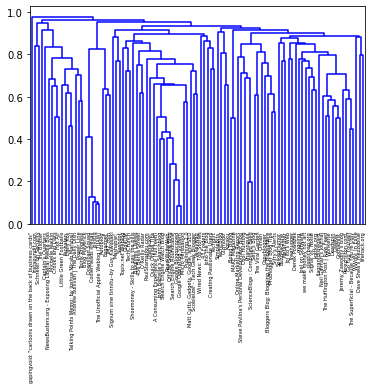

In [11]:
# let's create the dendrogram
scipy.cluster.hierarchy.dendrogram(linkage_matrix, labels = blogs, color_threshold  = 0)

plt.show()

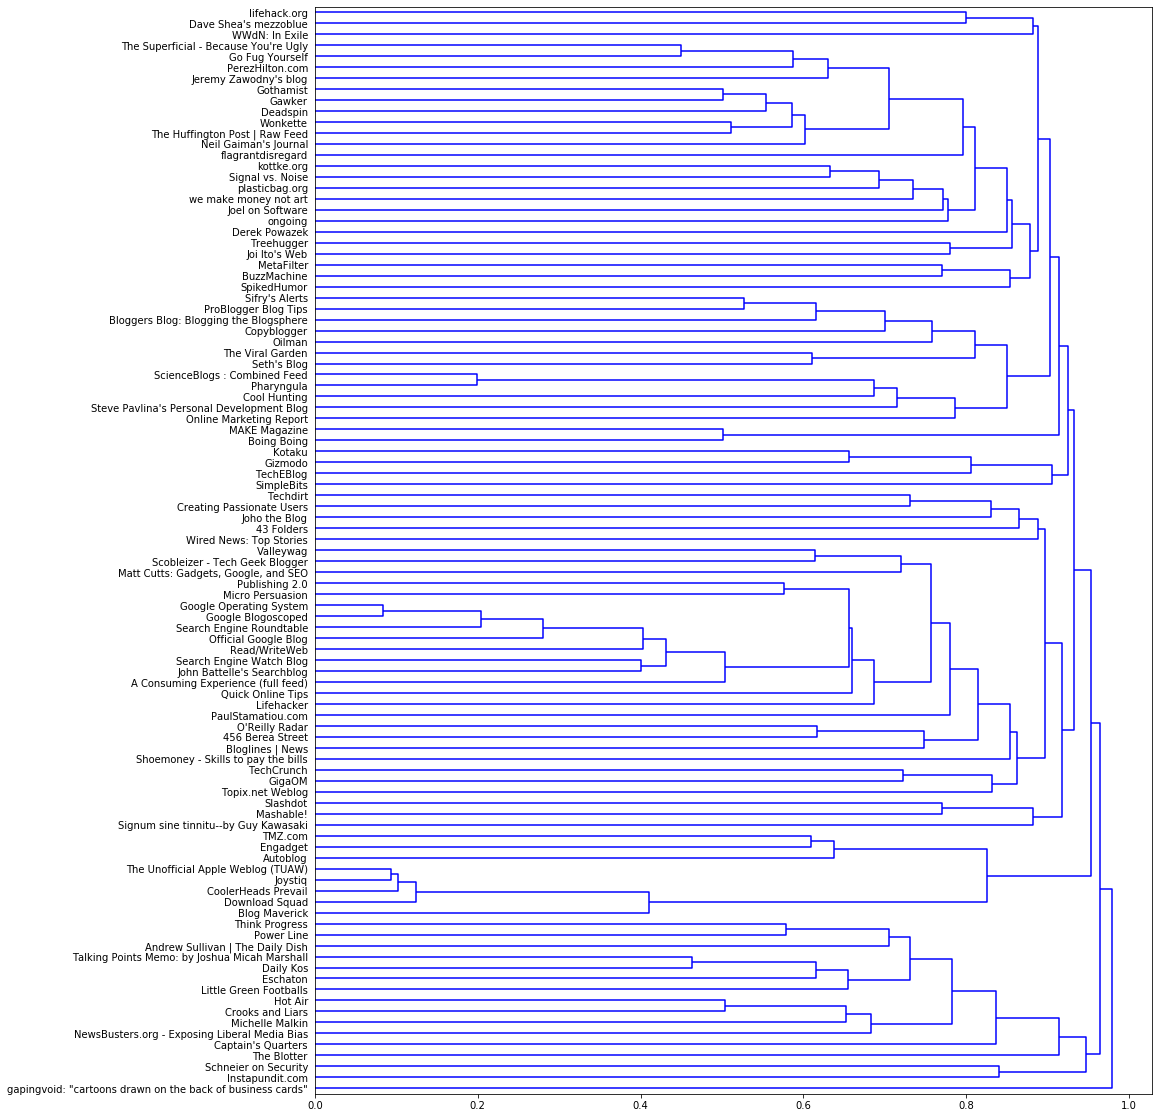

In [12]:
fig = plt.figure(figsize=(15, 20))

# now with leafs on the left, and the root node on the right
scipy.cluster.hierarchy.dendrogram(linkage_matrix, labels = blogs, color_threshold  = 0, orientation = 'right',
                                  leaf_font_size = 10)

plt.show()

#### HOW MANY CLUSTERS?

HAC does not require a pre-specified number of clusters, but we may want to partition our data as in flat clustering:

- cut at a pre-specified **level of similarity**: by default, the `dendrogram()` method colors all the descendent links below a cluster node k the same color if k is the first node below a cut threshold t. Its default values is `0.7*max(linkage_matrix[:,2])`, but other values can be used instead.

In [13]:
max_d = 0.75 * max(linkage_matrix[:,2])

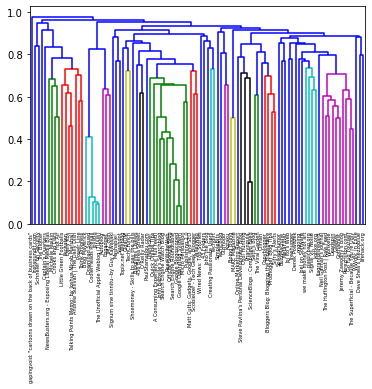

In [14]:
scipy.cluster.hierarchy.dendrogram(linkage_matrix, labels = blogs, color_threshold = max_d)

plt.show()

The `fcluster()` method, if the `"distance"` criterion is selected, allows us to retrieve the cluster id for each datapoint, when we cut our hierarchy at a given distance.

In [15]:
clusters = scipy.cluster.hierarchy.fcluster(linkage_matrix, max_d, criterion = "distance")
print(clusters)

[22 14 16  4  8  7 31 15 27 33  5 28  7 31 20  3  4 44 41 43  7  8  4 41
 12 24 41 16 16 41  3  1 41 39 16 21 36  7 24 16  4 27  9 17 34  3 16 41
  3 14 16 32 29 18 41 28  4 31 16 16 16  2 28 17 16 16 30 19 31 38 11 26
 10 35 28  8  4 12 25 20  6 41 41  7 30  4 13 37 17 46 23 41 42 47 38 45
 40 38 38]


In [17]:
# printing the contents of each cluster
cluster2blog = defaultdict(list)
for bid, clusterid in enumerate(clusters):
    cluster2blog[clusterid].append(blogs[bid])

for cId, blog in cluster2blog.items():
    print(cId, blog)

22 ['43 Folders']
14 ['456 Berea Street', "O'Reilly Radar"]
16 ['A Consuming Experience (full feed)', 'Google Blogoscoped', 'Google Operating System', "John Battelle's Searchblog", 'Lifehacker', 'Micro Persuasion', 'Official Google Blog', 'Publishing 2.0', 'Quick Online Tips', 'Read/WriteWeb', 'Search Engine Roundtable', 'Search Engine Watch Blog']
4 ['Andrew Sullivan | The Daily Dish', 'Daily Kos', 'Eschaton', 'Little Green Footballs', 'Power Line', 'Talking Points Memo: by Joshua Micah Marshall', 'Think Progress']
8 ['Autoblog', 'Engadget', 'TMZ.com']
7 ['Blog Maverick', 'CoolerHeads Prevail', 'Download Squad', 'Joystiq', 'The Unofficial Apple Weblog (TUAW)']
31 ['Bloggers Blog: Blogging the Blogsphere', 'Copyblogger', 'ProBlogger Blog Tips', "Sifry's Alerts"]
15 ['Bloglines | News']
27 ['Boing Boing', 'MAKE Magazine']
33 ['BuzzMachine']
5 ["Captain's Quarters"]
28 ['Cool Hunting', 'Pharyngula', 'ScienceBlogs : Combined Feed', "Steve Pavlina's Personal Development Blog"]
20 ['Creatin

- cut where a **pre-specified number of *k* clusters** can be obtained: `dendrogram()` method allows us to visualize only the last *k* merged clusters

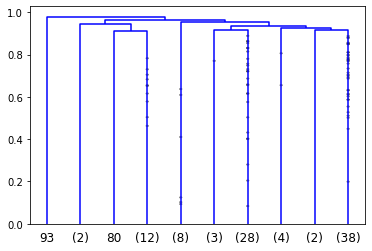

In [18]:
scipy.cluster.hierarchy.dendrogram(
    linkage_matrix,
    truncate_mode='lastp', p = 10, # show only the last 10 merged clusters
    show_leaf_counts=True,  # numbers in brackets are counts, others are ids
    show_contracted=True,  # show dots where hidden clusters are merged
)

plt.show()

Using the `"maxclust"` criterion of the `fcluster()` method, we can retrieve the ids of our desired *k* clusters.

In [19]:
clusters = scipy.cluster.hierarchy.fcluster(linkage_matrix, 10, criterion = "maxclust")
print(clusters)

[ 6  6  6  2  4  4  9  6  8  9  2  9  4  9  6  2  2  9  9  9  4  4  2  9
  6  7  9  6  6  9  2  1  9  9  6  6  9  4  7  6  2  8  5  6  9  2  6  9
  2  6  6  9  9  6  9  9  2  9  6  6  6  1  9  6  6  6  9  6  9  9  5  7
  5  9  9  4  2  6  7  6  3  9  9  4  9  2  6  9  6  9  6  9  9 10  9  9
  9  9  9]


### *K*-means

The algorithm:

```
Initialize K randomly selected centroid
while not converge do
	Assign each item to the cluster whose centroid is closest to it
	Recompute centroids of the new cluster found from previous step
end while
```

![alt text](data/k-means.png)

#### RESCALE YOUR DATA

Before running *K*-means, it is wise to rescale our observations. The `whiten()` method can be used to rescale each feature dimension (in our case our word counts) by their standard deviation across all observations to give it unit variance.

In [20]:
rescaledMat = scipy.cluster.vq.whiten(bwMat)

#### COMPUTING K-MEANS

The `kmeans()` performs *K*-means on a set of observations:

- the stopping criterion is that the change in distortion since the last iteration should be less than the parameter `"thresh"`(default = 1e-05);

    - **distortion**: the sum of the squared differences between the observations and the corresponding centroid.


- The number of times *K*-means should be run (default = 20), specified with parameter `"iter"`.


- For the iteration with the minimal distortion, it returns :

    - cluster centers: a $k$ by $N$ array of $k$ centroids, where the $i$th row is the centroid of code word $i$. The observation vectors and centroids have the same feature dimension;
    - the distortion between the observations and the centroids.

In [21]:
centroids, distortion = scipy.cluster.vq.kmeans(rescaledMat, 10)
print(centroids[0])

[0.         1.17632296 0.38193063 0.         1.08050018 0.44758365
 0.1479538  0.         3.11886607 1.39443535 2.61777609 0.25533109
 0.71277124 2.46470994 1.72268178 3.5157488  1.05430003 1.74113459
 0.33218297 3.12120241 0.         1.80507217 0.15834306 1.51119251
 1.42671441 0.35566597 2.09129003 0.34484623 1.23596372 0.50891504
 1.33438208 1.36672035 1.23759669 0.93638218 1.95187696 0.57147677
 1.45060901 0.53016614 1.69264433 2.00668164 0.64045816 0.52054819
 1.32634341 1.66345446 0.         0.07569126 0.27621108 0.2302911
 1.36024948 1.33073171 1.13996608 0.         2.59968443 1.26636549
 2.0733043  1.6132166  1.2625655  4.63858192 1.62264559 0.30150505
 1.96411501 0.53642583 0.44853815 2.57605393 1.5554189  2.14979082
 1.8049463  0.92309949 0.58459753 1.46027512 1.41987926 0.46145949
 2.13530962 0.13631709 2.11085201 1.25904723 0.         1.86820762
 0.79989717 1.91808604 2.02351508 1.02132436 1.54198873 0.33410121
 0.         2.57888108 0.         0.         0.21605114 1.28723

#### ASSIGNING DATAPOINTS TO CENTROIDS

The `vq()` method can be used to assign each observation to a given cluster:

- each observation vector is compared with the centroids and assigned to the nearest cluster.


- It returns:
    - an array holding the code book index for each observation;
    - the distortion between the observations and the centroids.

In [22]:
clusters, distortion = scipy.cluster.vq.vq(rescaledMat, centroids)

In [23]:
print(clusters)

[9 3 9 9 3 7 5 6 3 9 9 9 9 9 9 9 3 9 8 4 3 8 9 0 9 8 9 9 3 0 9 9 3 8 9 9 9
 9 8 8 8 3 9 9 9 9 9 8 9 6 3 9 9 3 9 9 9 9 9 3 8 9 8 9 9 9 9 9 8 8 9 9 9 9
 9 9 9 9 9 3 9 8 9 3 8 9 9 9 2 9 9 0 9 9 8 9 9 8 1]


In [25]:
# human readable
cluster2blog = defaultdict(list)
for bid, clusterid in enumerate(clusters):
    cluster2blog[clusterid].append(blogs[bid])
    
for cId, blog in cluster2blog.items():
    print(cId, blog)

9 ['43 Folders', 'A Consuming Experience (full feed)', 'Andrew Sullivan | The Daily Dish', 'BuzzMachine', "Captain's Quarters", 'Cool Hunting', 'CoolerHeads Prevail', 'Copyblogger', 'Creating Passionate Users', 'Crooks and Liars', "Dave Shea's mezzoblue", 'Eschaton', 'GigaOM', 'Go Fug Yourself', 'Google Blogoscoped', 'Hot Air', 'Instapundit.com', "John Battelle's Searchblog", 'Joho the Blog', "Joi Ito's Web", 'Joystiq', 'Mashable!', 'Matt Cutts: Gadgets, Google, and SEO', 'MetaFilter', 'Michelle Malkin', 'Micro Persuasion', 'NewsBusters.org - Exposing Liberal Media Bias', 'Oilman', 'Online Marketing Report', 'PerezHilton.com', 'Pharyngula', 'Power Line', 'ProBlogger Blog Tips', 'Publishing 2.0', 'Schneier on Security', 'Scobleizer - Tech Geek Blogger', 'Search Engine Roundtable', 'Search Engine Watch Blog', "Seth's Blog", 'Shoemoney - Skills to pay the bills', 'Signum sine tinnitu--by Guy Kawasaki', 'SimpleBits', 'Slashdot', 'SpikedHumor', "Steve Pavlina's Personal Development Blog", '

#### PLOTTING OUR DATA

##### Plotting the data directly

Adjusted example and code from [scipy.cluster.vq.kmeans](https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.vq.kmeans.html):

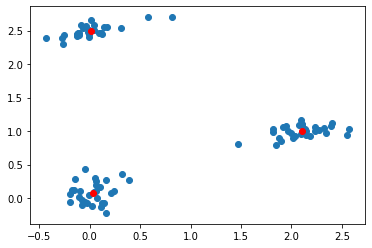

In [26]:
from scipy.cluster.vq import vq, kmeans, whiten

# Create 50 datapoints in two clusters a and b
pts = 30
a = np.random.multivariate_normal([0, 0], [[4, 1], [1, 4]], size=pts)
b = np.random.multivariate_normal([30, 10], [[10, 2], [2, 1]], size=pts)
c = np.random.multivariate_normal([0, 25], [[10, 2], [2, 1]], size=pts)
features = np.concatenate((a, b, c))

# Whiten data
whitened = whiten(features)

# Find 2 clusters in the data
codebook, distortion = kmeans(whitened, 3)

# Plot whitened data and cluster centers in red
plt.scatter(whitened[:, 0], whitened[:, 1])
plt.scatter(codebook[:, 0], codebook[:, 1], c='r')
plt.show()

---

#### Exercise

`Zebo` was a social network encoraging people to create lists of things that they own and things that they would like to own. The dataset `./data/zebo.txt` reports an item-to-user matrix of binary values

- **Task**: Use a clustering method to group together the preferences expressed by these users.

In [ ]:
# your code here

---

## Topic Modelling

> What follows is a short tutorial on using the LDA implementation available in [Gensim](https://radimrehurek.com/gensim/). 
>
>
> To install Gensim, either use the Anaconda Navigator or:
>
> ```conda install -c anaconda gensim```

### Pre-process the documents

In this tutorial we will work with the `C-Span Inaugural Address Corpus` available in NLTK.

In [33]:
print(nltk.corpus.inaugural.readme())

C-Span Inaugural Address Corpus

US presidential inaugural addresses 1789-2017

(Thanks to Kathleen Ahrens for compiling this corpus from
the C-Span sources.)




As a first step, we lemmatize our corpus:

- as usual, we need pos-tagging to properly use the WordNet based lemmatizer.

In [34]:
un2wn_mapping = {"VERB" : wn.VERB, "NOUN" : wn.NOUN, "ADJ" : wn.ADJ, "ADV" : wn.ADV}

inaug_docs = []

for speech_id in nltk.corpus.inaugural.fileids(): # NB: fileids()
    lemmatized_doc = []
    for w, p in nltk.pos_tag(nltk.corpus.inaugural.words(speech_id), tagset="universal"):
        if p in un2wn_mapping.keys():
            lemma = nltk.WordNetLemmatizer().lemmatize(w, pos = un2wn_mapping[p])
        else:
            lemma = nltk.WordNetLemmatizer().lemmatize(w)
            
        lemmatized_doc.append(lemma.lower())  # case insensitive
        
    inaug_docs.append(lemmatized_doc)

### Construct the document-term matrix

The `gensim.corpora.Dictionary()` class encapsulates the mapping between normalized words and their integer ids:

- we use it to create a dictionary representation of our documents.

In [35]:
inaug_dictionary = corpora.Dictionary(inaug_docs)
print('Number of unique tokens:', len(inaug_dictionary))

Number of unique tokens: 7091


In [36]:
# let's check each token's unique id
print(dict(itertools.islice(inaug_dictionary.token2id.items(), 12)))
print("word with id 8:", inaug_dictionary[8])
print("frequency of token 8:", inaug_dictionary.dfs[8])

{'"': 0, '(': 1, ')': 2, ',': 3, '-': 4, '--': 5, '.': 6, '."': 7, '14th': 8, ':': 9, ';': 10, 'a': 11}
word with id 8: 14th
frequency of token 8: 1


Using built-in function `filter_extremes()`, we can remove rare and common words based on their document frequency. 

- the `filter_extremes(self, no_below=5, no_above=0.5, keep_n=100000, keep_tokens=None)` allows us to remove words that appear in:
    - less than `no_below` documents (absolute number);
    - more than `no_above` documents (fraction of total corpus size);
    - if tokens are given in `keep_tokens` (list of strings), they are kept regardless of all the other settings;
    - after the other parameters have been applied, keep only the first `keep_n` most frequent tokens (all if `None`).

In [37]:
# Filter out words that occur in less than 10 documents, or more than 50% of the documents.
inaug_dictionary.filter_extremes(no_below=10, no_above=0.5)
print('Number of unique tokens:', len(inaug_dictionary))

Number of unique tokens: 848


The `doc2bow()` function is the most important `Dictionary()` method, whose function is to convert a collection of words to a **bag-of-words representation**.

In [38]:
# Bag-of-words representation of the documents
inaug_bow_corpus = [inaug_dictionary.doc2bow(d) for d in inaug_docs]

Such a representation returns, **for each document**, a list of `(word_id, word_frequency) 2-tuples`:

- we can use the dictionary mapping to retrieve the lemma associated with a given id.

In [39]:
# Our first document, i.e. at index 0 of `bow_corpus`
print(nltk.corpus.inaugural.raw('1789-Washington.txt')[:1890])

Fellow-Citizens of the Senate and of the House of Representatives:

Among the vicissitudes incident to life no event could have filled me with greater anxieties than that of which the notification was transmitted by your order, and received on the 14th day of the present month. On the one hand, I was summoned by my Country, whose voice I can never hear but with veneration and love, from a retreat which I had chosen with the fondest predilection, and, in my flattering hopes, with an immutable decision, as the asylum of my declining years -- a retreat which was rendered every day more necessary as well as more dear to me by the addition of habit to inclination, and of frequent interruptions in my health to the gradual waste committed on it by time. On the other hand, the magnitude and difficulty of the trust to which the voice of my country called me, being sufficient to awaken in the wisest and most experienced of her citizens a distrustful scrutiny into his qualifications, could not bu

In [40]:
# the BOW representation of the first document
print(inaug_bow_corpus[0][:50])

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 2), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 2), (28, 2), (29, 1), (30, 1), (31, 3), (32, 1), (33, 1), (34, 2), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1), (40, 1), (41, 1), (42, 1), (43, 1), (44, 1), (45, 2), (46, 1), (47, 1), (48, 1), (49, 1)]


In [41]:
# which words (and how often) appear in the first document?
for i, freq in sorted(inaug_bow_corpus[0], key=itemgetter(1), reverse=True)[:15]:
    print(inaug_dictionary[i], "-->", freq)
print("...")

myself --> 4
ought --> 4
circumstance --> 3
establish --> 3
happiness --> 3
nature --> 3
assure --> 2
blessing --> 2
care --> 2
community --> 2
decide --> 2
department --> 2
event --> 2
execute --> 2
executive --> 2
...


---

#### Applying the LDA model

Now we can train the LDA model by using the `gensim.models.ldamodel.LDAModel()` constructor.

Parameters used in our example:

- `num_topics`: how many topics do we want? In what follows, we set the number of topics to 5, because we want to have a few topics that we can interpret, but the number of topics is **data** and **application**-dependent;


- `id2word`: our previous dictionary needed to map ids to strings;



- `passes`: how often we iterateover the entire corpus (default = 1). In general, the more the passes, the higher the accuracy. This number is also called `epochs` in ML literature.

In [42]:
inaug_ldamodel = models.ldamodel.LdaModel(inaug_bow_corpus, num_topics=5, id2word = inaug_dictionary, passes= 25)

Even if we are not covering these issues, it is importatnt to know that:

- you can use this model to infer the topic distribution in **a new unseen document**:

```python
doc_lda = inaug_ldamodel[doc_bow]
```


- you can **update** you model with novel data (instead of retraining from scratch):

```python
inaug_ldamodel.update(new_corpus)
```

### Examining Topics

An immediate way to inspect our topics is by using the `show_topics()` method, that prints the most representative words for each topic (each topic is marked by an integer id), along with their probability.

In [46]:
# let's see just 5 words per topic (default = 10)
inaug_ldamodel.show_topics(num_words=5)

[(0,
  '0.014*"congress" + 0.009*"business" + 0.008*"condition" + 0.006*"race" + 0.006*"executive"'),
 (1,
  '0.011*"thing" + 0.010*"democracy" + 0.009*"economic" + 0.008*"civilization" + 0.008*"task"'),
 (2,
  '0.007*"opinion" + 0.006*"object" + 0.006*"executive" + 0.006*"institution" + 0.006*"general"'),
 (3,
  '0.014*"today" + 0.014*"century" + 0.013*"americans" + 0.011*"generation" + 0.010*"build"'),
 (4,
  '0.013*"today" + 0.011*"help" + 0.011*"earth" + 0.010*"again" + 0.010*"americans"')]

In [47]:
# the setting formatted=False allows you to get rid of the word*probability format when retrieveing topics
inaug_ldamodel.show_topics(formatted=False, num_words=10)

[(0,
  [('congress', 0.014140481),
   ('business', 0.0093024345),
   ('condition', 0.0075770696),
   ('race', 0.0064101433),
   ('executive', 0.0061434684),
   ('increase', 0.005809959),
   ('revenue', 0.0057905284),
   ('necessary', 0.0057278504),
   ('ought', 0.005417626),
   ('labor', 0.0053896834)]),
 (1,
  [('thing', 0.010629142),
   ('democracy', 0.009719583),
   ('economic', 0.009120638),
   ('civilization', 0.008227594),
   ('task', 0.00819473),
   ('opportunity', 0.007753881),
   ('republic', 0.007554688),
   ('thought', 0.0067014294),
   ('problem', 0.006527296),
   ('order', 0.006225285)]),
 (2,
  [('opinion', 0.0065768915),
   ('object', 0.0064775813),
   ('executive', 0.0062681353),
   ('institution', 0.006263179),
   ('general', 0.005626477),
   ('necessary', 0.0048418315),
   ('limit', 0.0047417297),
   ('exist', 0.004713355),
   ('authority', 0.004605751),
   ('regard', 0.004553977)]),
 (3,
  [('today', 0.0141304415),
   ('century', 0.013810536),
   ('americans', 0.0134

The `get_term_topics()` method returns the odds of that particular word belonging to a particular topic:

- topics below a given threshold are ignored.

In [48]:
inaug_ldamodel.get_term_topics("congress", minimum_probability = 1e-3)

[(0, 0.014050201), (2, 0.0040861676), (3, 0.0022967777), (4, 0.0017318719)]

The `get_document_topics()` returns several statistics describing the topic distribution in a document:

- the topic distribution of the document;


- (if `per_word_topics=True`) the the topic distribution for each word in the document;


- (if `per_word_topics=True`) the probability of each word in each document to belong to a particular topic.

In [50]:
# the topics of the first document of our corpus
inaug_ldamodel.get_document_topics(inaug_bow_corpus[0], minimum_probability = 0)

[(0, 0.00085566),
 (1, 0.0008522134),
 (2, 0.99658746),
 (3, 0.0008539308),
 (4, 0.00085071207)]

In [51]:
# the topics of ALL the documents of our corpus
for doc_topics in inaug_ldamodel.get_document_topics(inaug_bow_corpus):
    print(doc_topics)

[(2, 0.9965882)]
[(2, 0.96297276)]
[(2, 0.9976793)]
[(2, 0.9331537), (3, 0.06482706)]
[(2, 0.9978613)]
[(2, 0.9960719)]
[(2, 0.8845566), (4, 0.112198606)]
[(2, 0.9985426)]
[(0, 0.019416338), (2, 0.9797845)]
[(2, 0.998448)]
[(2, 0.9961048)]
[(2, 0.9960783)]
[(2, 0.99893945)]
[(2, 0.9927283)]
[(0, 0.06547872), (2, 0.9338433)]
[(0, 0.1779427), (2, 0.81926435)]
[(0, 0.056809053), (1, 0.102318816), (2, 0.84018743)]
[(0, 0.21903944), (2, 0.7797757)]
[(0, 0.23327568), (2, 0.7656988)]
[(0, 0.15348287), (2, 0.4902972), (4, 0.3524243)]
[(0, 0.34364608), (2, 0.5783606), (4, 0.07571455)]
[(0, 0.19144925), (1, 0.13776785), (2, 0.6690763)]
[(0, 0.6068058), (2, 0.39188114)]
[(0, 0.6623133), (2, 0.18303588), (4, 0.14898701)]
[(0, 0.38732672), (1, 0.09118435), (2, 0.5200746)]
[(0, 0.9412506), (2, 0.057959408)]
[(0, 0.55285263), (2, 0.4039236), (3, 0.0420234)]
[(0, 0.8915584), (2, 0.10762441)]
[(0, 0.65482104), (1, 0.016614672), (2, 0.23132607), (3, 0.096735254)]
[(1, 0.84584856), (4, 0.15072589)]
[(0, 

In [54]:
# the topics of the first document of our corpus, of its words and the scaled prob values of each word.
doc_topics, word_topics, phi_values = inaug_ldamodel.get_document_topics(inaug_bow_corpus[0], per_word_topics=True)

# "Topic distribution for the whole document. Each element in the list is a pair of topic_id, 
# and the probability that was assigned to it."
print("- Document topics:", doc_topics)

# "Most probable topics for a word. Each element in the list is a pair of word_id, and a list of 
# topics sorted by their relevance to this word."
print("\n- Word topics:", word_topics)

# "Relevance values multipled by the feature length, for each word-topic combination. Each element
# in the list is a pair of word_id, and a list of the values between this word and each topic."
print("\n- Scaled phi values:", phi_values)

- Document topics: [(2, 0.9965868)]

- Word topics: [(0, [2]), (1, [2]), (2, [2]), (3, [2]), (4, [2]), (5, [2]), (6, [2]), (7, [2]), (8, [2]), (9, [2]), (10, [2]), (11, [2]), (12, [2]), (13, [2]), (14, [2]), (15, [2]), (16, [2]), (17, [2]), (18, [2]), (19, [2]), (20, [2]), (21, [2]), (22, [2]), (23, [2]), (24, [2]), (25, [2]), (26, [2]), (27, [2]), (28, [2]), (29, [2]), (30, [2]), (31, [2]), (32, [2]), (33, [2]), (34, [2]), (35, [2]), (36, [2]), (37, [2]), (38, [2]), (39, [2]), (40, [2]), (41, [2]), (42, [2]), (43, [2]), (44, [2]), (45, [2]), (46, [2]), (47, [2]), (48, [2]), (49, [2]), (50, [2]), (51, [2]), (52, [2]), (53, [2]), (54, [2]), (55, [2]), (56, [2]), (57, [2]), (58, [2]), (59, [2]), (60, [2]), (61, [2]), (62, [2]), (63, [2]), (64, [2]), (65, [2]), (66, [2]), (67, [2]), (68, [2]), (69, [2]), (70, [2]), (71, [2]), (72, [2]), (73, [2]), (74, [2]), (75, [2]), (76, [2]), (77, [2]), (78, [2]), (79, [2]), (80, [2]), (81, [2]), (82, [2]), (83, [2]), (84, [2]), (85, [2]), (86, [2]), 

---

#### Exercise

What follows is the raw text from the Trump inaugural speech. 

Use your model to **infer and have a look at the topics distribution** of this document.

In [55]:
trump_speech = "We, the citizens of America, are now joined in a great national effort to rebuild our country and to restore its promise for all of our people.\n\nTogether, we will determine the course of America and the world for years to come.\n\nWe will face challenges. We will confront hardships. But we will get the job done.\n\nEvery four years, we gather on these steps to carry out the orderly and peaceful transfer of power, and we are grateful to President Obama and First Lady Michelle Obama for their gracious aid throughout this transition. They have been magnificent.\n\nToday\u2019s ceremony, however, has very special meaning. Because today we are not merely transferring power from one Administration to another, or from one party to another \u2013 but we are transferring power from Washington, D.C. and giving it back to you, the American People.\n\nFor too long, a small group in our nation\u2019s Capital has reaped the rewards of government while the people have borne the cost.\n\nWashington flourished \u2013 but the people did not share in its wealth.\n\nPoliticians prospered \u2013 but the jobs left, and the factories closed.\n\nThe establishment protected itself, but not the citizens of our country.\n\nTheir victories have not been your victories; their triumphs have not been your triumphs; and while they celebrated in our nation\u2019s Capital, there was little to celebrate for struggling families all across our land.\n\nThat all changes \u2013 starting right here, and right now, because this moment is your moment: it belongs to you.\n\nIt belongs to everyone gathered here today and everyone watching all across America. \n\nThis is your day. This is your celebration.\n\nAnd this, the United States of America, is your country.\n\nWhat truly matters is not which party controls our government, but whether our government is controlled by the people.\n\nJanuary 20th 2017, will be remembered as the day the people became the rulers of this nation again. \n\nThe forgotten men and women of our country will be forgotten no longer.\n\nEveryone is listening to you now.\n\nYou came by the tens of millions to become part of a historic movement the likes of which the world has never seen before.\n\nAt the center of this movement is a crucial conviction: that a nation exists to serve its citizens.\n\nAmericans want great schools for their children, safe neighborhoods for their families, and good jobs for themselves.\n\nThese are the just and reasonable demands of a righteous public.\n\nBut for too many of our citizens, a different reality exists: Mothers and children trapped in poverty in our inner cities; rusted-out factories scattered like tombstones across the landscape of our nation; an education system, flush with cash, but which leaves our young and beautiful students deprived of knowledge; and the crime and gangs and drugs that have stolen too many lives and robbed our country of so much unrealized potential.\n\nThis American carnage stops right here and stops right now.\n\nWe are one nation \u2013 and their pain is our pain.  Their dreams are our dreams; and their success will be our success.  We share one heart, one home, and one glorious destiny.\n\nThe oath of office I take today is an oath of allegiance to all Americans.\n\nFor many decades, we\u2019ve enriched foreign industry at the expense of American industry;\n\nSubsidized the armies of other countries while allowing for the very sad depletion of our military;\n\nWe've defended other nation\u2019s borders while refusing to defend our own;\n\nAnd spent trillions of dollars overseas while America's infrastructure has fallen into disrepair and decay.\n\nWe\u2019ve made other countries rich while the wealth, strength, and confidence of our country has disappeared over the horizon.\n\nOne by one, the factories shuttered and left our shores, with not even a thought about the millions upon millions of American workers left behind.\n\nThe wealth of our middle class has been ripped from their homes and then redistributed across the entire world.\n\nBut that is the past. And now we are looking only to the future.\n\nWe assembled here today are issuing a new decree to be heard in every city, in every foreign capital, and in every hall of power.\n\nFrom this day forward, a new vision will govern our land.\n\nFrom this moment on, it\u2019s going to be America First.\n\nEvery decision on trade, on taxes, on immigration, on foreign affairs, will be made to benefit American workers and American families.\n\nWe must protect our borders from the ravages of other countries making our products, stealing our companies, and destroying our jobs.  Protection will lead to great prosperity and strength.\n\nI will fight for you with every breath in my body \u2013 and I will never, ever let you down.\n\nAmerica will start winning again, winning like never before.\n\nWe will bring back our jobs. We will bring back our borders.  We will bring back our wealth.  And we will bring back our dreams.\n\nWe will build new roads, and highways, and bridges, and airports, and tunnels, and railways all across our wonderful nation.\n\nWe will get our people off of welfare and back to work \u2013 rebuilding our country with American hands and American labor.\n\nWe will follow two simple rules: Buy American and Hire American.\n\nWe will seek friendship and goodwill with the nations of the world \u2013 but we do so with the understanding that it is the right of all nations to put their own interests first.\n\nWe do not seek to impose our way of life on anyone, but rather to let it shine as an example for everyone to follow.\n\nWe will reinforce old alliances and form new ones \u2013 and unite the civilized world against Radical Islamic Terrorism, which we will eradicate completely from the face of the Earth.\n\nAt the bedrock of our politics will be a total allegiance to the United States of America, and through our loyalty to our country, we will rediscover our loyalty to each other.\n\nWhen you open your heart to patriotism, there is no room for prejudice.\n\nThe Bible tells us, \u201chow good and pleasant it is when God\u2019s people live together in unity.\u201d\n\nWe must speak our minds openly, debate our disagreements honestly, but always pursue solidarity.\n\nWhen America is united, America is totally unstoppable.\n\nThere should be no fear \u2013 we are protected, and we will always be protected.\n\nWe will be protected by the great men and women of our military and law enforcement and, most importantly, we are protected by God.\n\nFinally, we must think big and dream even bigger.\n\nIn America, we understand that a nation is only living as long as it is striving.\n\nWe will no longer accept politicians who are all talk and no action \u2013 constantly complaining but never doing anything about it.\n\nThe time for empty talk is over.\n\nNow arrives the hour of action.\n\nDo not let anyone tell you it cannot be done.  No challenge can match the heart and fight and spirit of America.\n\nWe will not fail. Our country will thrive and prosper again.\n\nWe stand at the birth of a new millennium, ready to unlock the mysteries of space, to free the Earth from the miseries of disease, and to harness the energies, industries and technologies of tomorrow.\n\nA new national pride will stir our souls, lift our sights, and heal our divisions.\n\nIt is time to remember that old wisdom our soldiers will never forget: that whether we are black or brown or white, we all bleed the same red blood of patriots, we all enjoy the same glorious freedoms, and we all salute the same great American Flag.\n\nAnd whether a child is born in the urban sprawl of Detroit or the windswept plains of Nebraska, they look up at the same night sky, they fill their heart with the same dreams, and they are infused with the breath of life by the same almighty Creator.\n\nSo to all Americans, in every city near and far, small and large, from mountain to mountain, and from ocean to ocean, hear these words:\n\nYou will never be ignored again.\n\nYour voice, your hopes, and your dreams, will define our American destiny. And your courage and goodness and love will forever guide us along the way.\n\nTogether, We Will Make America Strong Again.\n\nWe Will Make America Wealthy Again.\n\nWe Will Make America Proud Again.\n\nWe Will Make America Safe Again.\n\nAnd, Yes, Together, We Will Make America Great Again. Thank you, God Bless You, And God Bless America."

In [ ]:
# your code here

---

#### Visualizing Topics

When we have several document or topics, usually plotting data is the best way to make sense of your results.

- First of all, let's encode our document to topic mapping in a numpy matrix to simplify our processing.

In [56]:
docs_id = nltk.corpus.inaugural.fileids()

doc2topics = np.zeros((len(docs_id), inaug_ldamodel.num_topics))

for di, doc_topics in enumerate(inaug_ldamodel.get_document_topics(inaug_bow_corpus, minimum_probability = 0)):
    for ti, v in doc_topics:
        doc2topics[di, ti] = v

# print(doc2topics)

- We can check the **share of a given topic in the documents of our corpus** in a barplot:

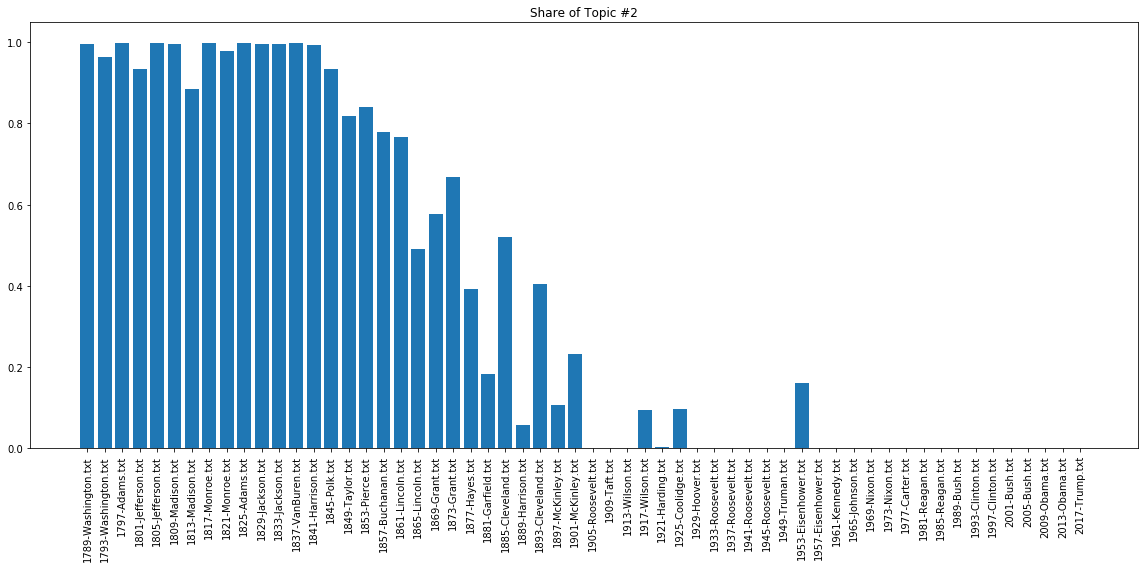

In [63]:
which_topic = 2 # try to change this and see what happens!

ind = range(len(docs_id))
fig = plt.figure(figsize=(16, 8))
plt.bar(ind, doc2topics[:,which_topic])
plt.xticks(ind, docs_id, rotation = 90)
plt.title('Share of Topic #%d'%which_topic)
plt.tight_layout()  # fixes margins
plt.show()

- We can check the **share of all the topics in all the documents** by using a heatmap:

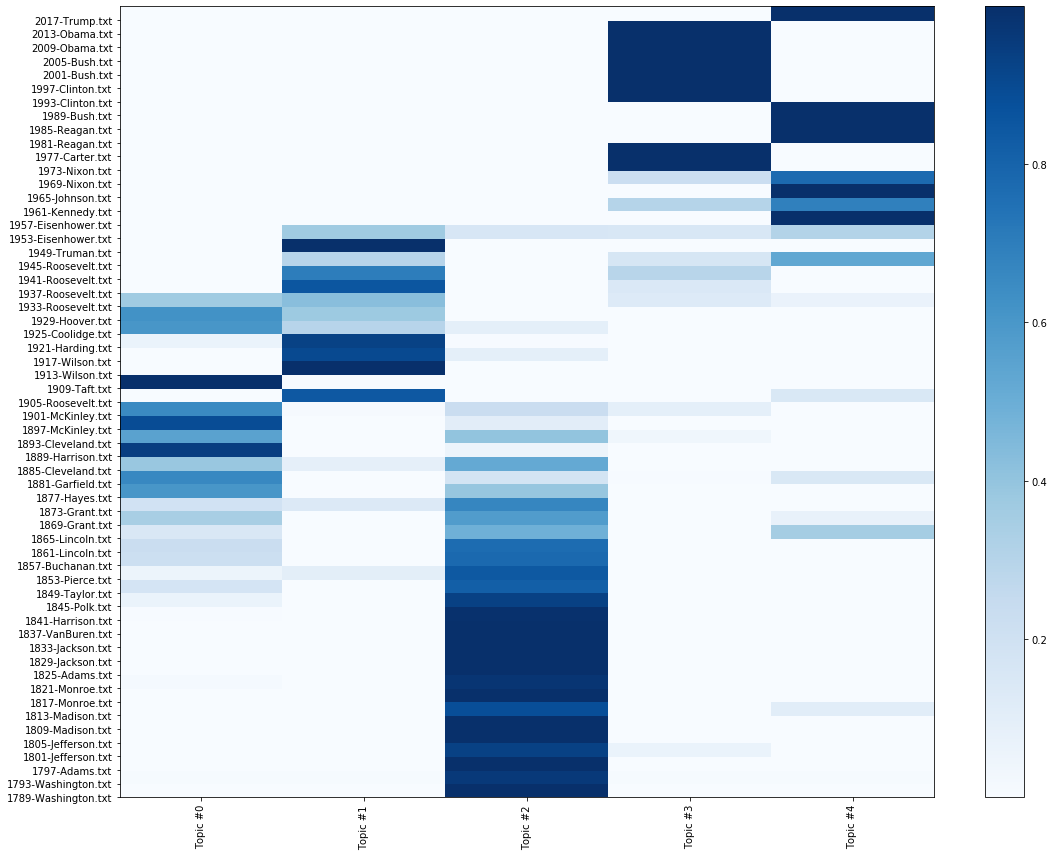

In [65]:
fig = plt.figure(figsize=(16, 12))
plt.pcolor(doc2topics, norm=None, cmap='Blues')
plt.yticks(np.arange(doc2topics.shape[0]), docs_id)
plt.xticks(np.arange(doc2topics.shape[1])+0.5, ["Topic #"+str(n) for n in range(inaug_ldamodel.num_topics)], rotation = 90)
plt.colorbar(cmap='Blues')  # plot colorbar
plt.tight_layout()  # fixes margins
plt.show()

- A nice way to visualize the distribution over words that characterizes each topic is by printing, for each topic, the top-assocaited words resized **according to their strength of association** with the topic.

> **Credits**:
>
> The following code has been adapted from the **Text Analysis with Topic Models for the Humanities and Social Sciences** tutorials by Allen Riddell.

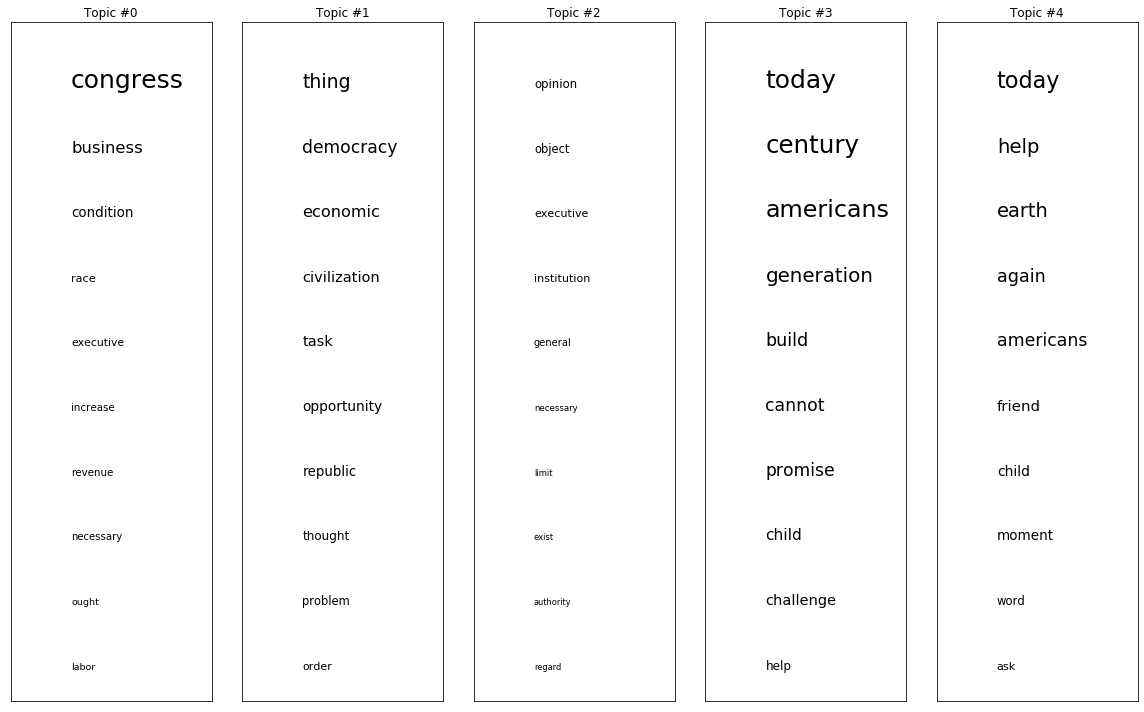

In [67]:
fig = plt.figure(figsize=(16, 10))

num_top_words = 10

topic2top_words = dict(inaug_ldamodel.show_topics(formatted=False, num_words = num_top_words))
fontsize_base = 25 / max([w[0][1] for w in topic2top_words.values()]) # font size for word with largest share in corpus

for topic, words_shares in topic2top_words.items():
    plt.subplot(1, inaug_ldamodel.num_topics, topic + 1)
    plt.ylim(0, num_top_words + 0.5)  # stretch the y-axis to accommodate the words
    plt.xticks([])  # remove x-axis markings ('ticks')
    plt.yticks([]) # remove y-axis markings ('ticks')
    plt.title('Topic #{}'.format(topic))
    for i, (word, share) in enumerate(words_shares):
        plt.text(0.3, num_top_words-i-0.5, word, fontsize=fontsize_base*share)
        
plt.tight_layout()
plt.show()

---

#### Exercise

* Try to play with the topic mode, and especially try to change the number of topics. What happens? How do they distribute over time and presidents?

* Use Gensim's `gensim.models.Phrases` class to calculate high-frequency bigrams and trigrams, add them to your bag-of-words document representation and train the topic model again. Does this improve your results?

---